## Derivatives Pricing

The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing
problem is defined in the regression framework, where the predicted variable is the
pricing of the option, and the predictor variables are the market data that are used as
inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Vol Suface

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

### Simulation

In this exercise, we assume the the structure of the vol surface. In practice, we would source the data from a data vendor.


We use the following function to generate the option volatility surface

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Python Imports

In [1]:
import os
import sys


root_dir = os.path.abspath('../..')
sys.path.append(root_dir)
from functions import (
    ParamsKfold, ResultKfold, ParamsGridSearch, 
    calc_best_features, run_kfold_analysis, run_grid_search, show_corr_matrix, show_scatter_matrix, 
    show_seasonal_decomposition, show_boxplot_kfold, show_bar_kfold,
    LINEAR_MODELS, NEURAL_NETWORK_MODELS, ENSEMBLE_MODELS
)
from case_study_2 import ParamsCallOPtion, calc_opt_volatility, calc_opt_price

In [2]:
# Core libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error


In [3]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')


<a id='1.3'></a>
## 2.3. Data Generation

In [4]:
N = 10000 # Number of data points
params_call_opt = ParamsCallOPtion(true_alpha=0.1, true_beta=0.1, true_sigma0=0.2, risk_free_rate=0.0)
Moneynesses = 1 + (0.25 * np.random.randn(N))
Times_to_mat = np.random.random(N)

Sigmas = calc_opt_volatility(Moneynesses, Times_to_mat, params_call_opt)
Prices = calc_opt_price(Moneynesses, Times_to_mat, Sigmas, params_call_opt)


### Set the Endog and Exog Data

In [5]:
X = pd.DataFrame({'Moneyness': Moneynesses, 'Time': Times_to_mat, 'Volatility': Sigmas})
Y = pd.DataFrame({'Price': Prices})

dataset = pd.concat([Y, X], axis=1).fillna(0.0)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
dataset.head()

,Price,Moneyness,Time,Volatility
0,0.007022,1.526411,0.450140,0.272725
1,0.000079,1.286430,0.108494,0.219054
2,0.249504,0.946224,0.961780,0.296467
3,0.013357,1.291289,0.328850,0.241370
4,0.128440,1.070753,0.590725,0.259573


In [7]:
dataset.describe()

,Price,Moneyness,Time,Volatility
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.166195,1.000367,0.495505,0.255690
std,0.131780,0.247796,0.288888,0.030175
min,0.000000,0.097400,0.000058,0.200232
25%,0.064586,0.834409,0.247021,0.230696
50%,0.145486,1.000984,0.491326,0.255362
75%,0.239176,1.164570,0.746080,0.280519
max,0.902600,1.908373,0.999967,0.374293


<a id='2.2'></a>
## 3.2. Data Visualization

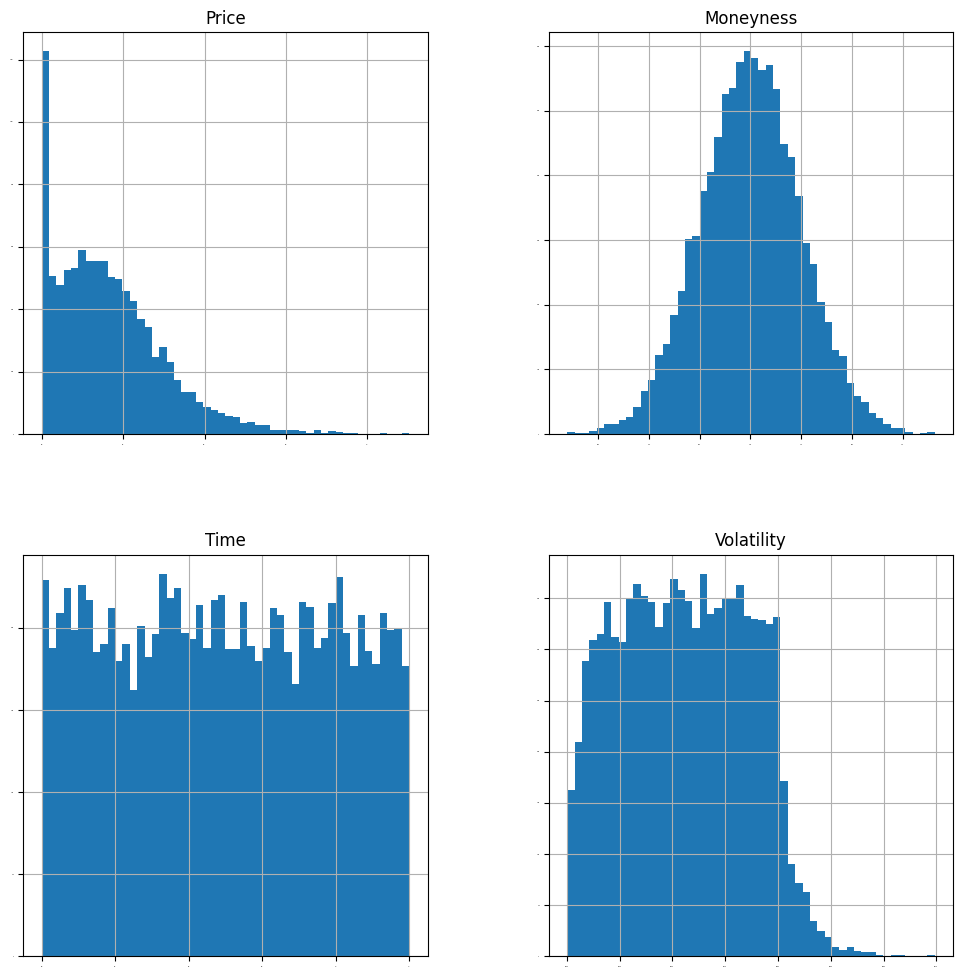

In [8]:
dataset.hist(
    bins=50, 
    sharex=False, 
    sharey=False, 
    xlabelsize=1, 
    ylabelsize=1, 
    figsize=(12, 12)
)
plt.show()


We can see that the price has an interesting distribution with a spike at $0$

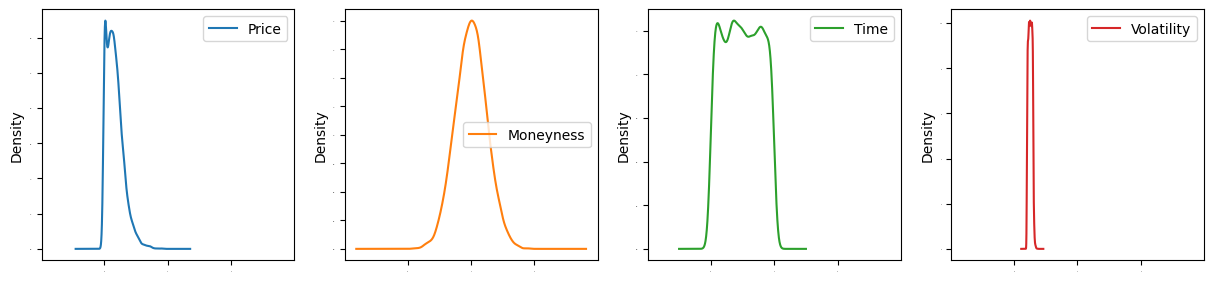

In [9]:
dataset.plot(
    kind='density', 
    subplots=True, 
    layout=(4, 4), 
    sharex=True, 
    legend=True, 
    fontsize=1, 
    figsize=(15, 15)
)
plt.show()


Next we look at the interaction between different variables

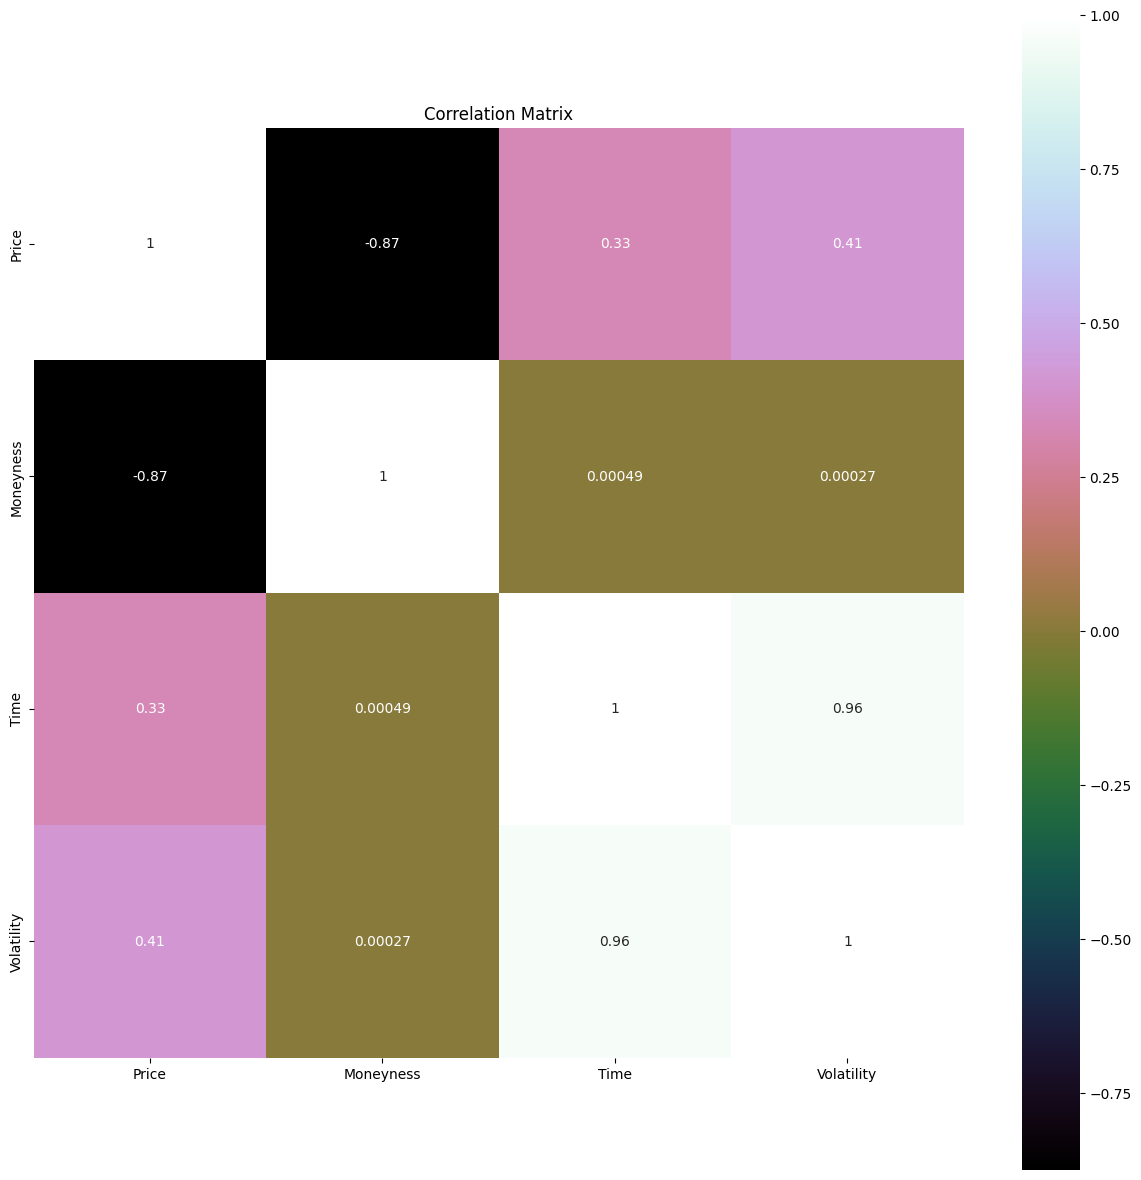

In [10]:
show_corr_matrix(dataset)


<Figure size 1500x1500 with 0 Axes>

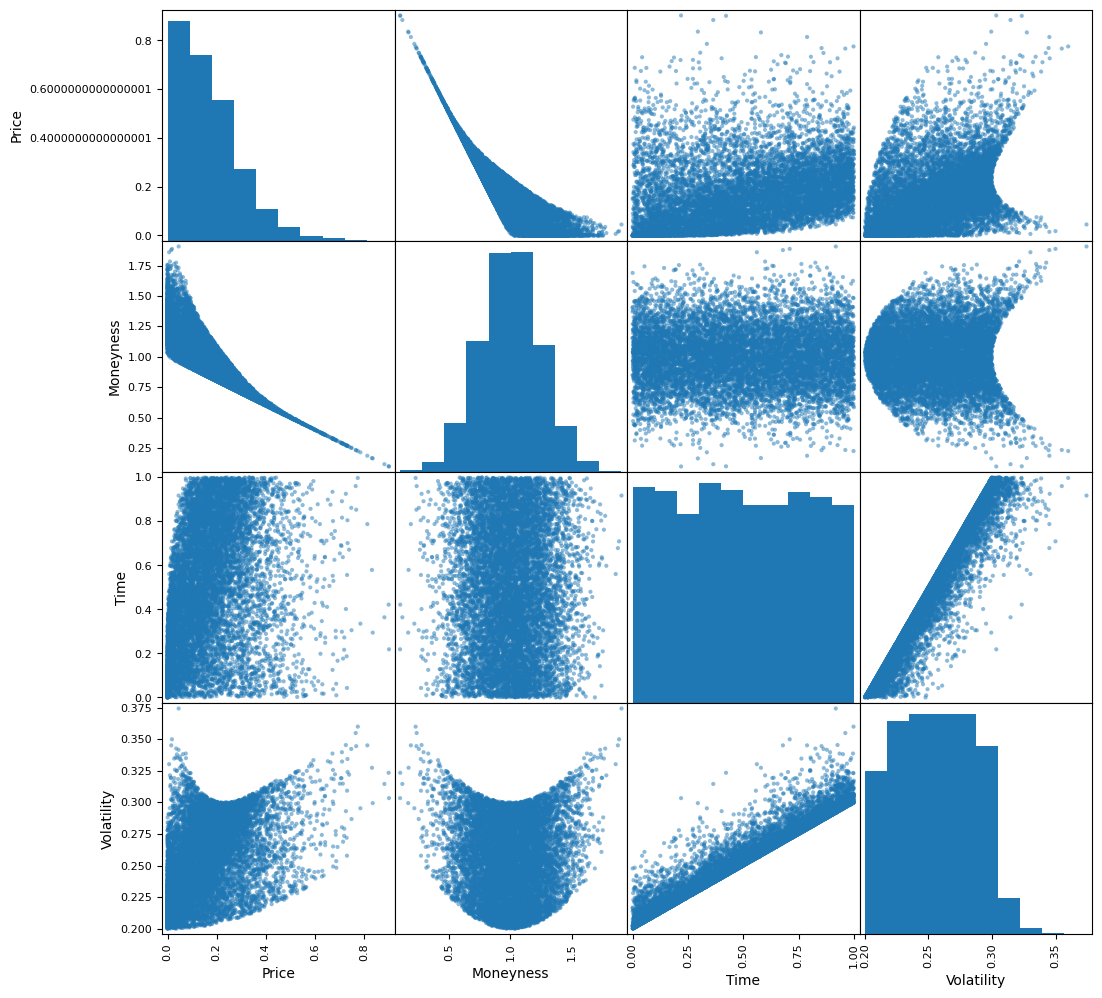

In [11]:
show_scatter_matrix(dataset)


We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models.

<a id='3'></a>
## 4. Data Preparation and Analysis

<a id='4.1'></a>
## 4.1. Univariate Feature Selection

We use SelectKBest function from sklearn

In [12]:
calc_best_features(X, Y, n_features='all')


----------------------------------------------------------------
                   Score
Specs                   
Moneyness   32610.757486
Volatility   2025.738154
Time         1233.119737


We observe that the moneyness is the most important variable for the price.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [13]:
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
models = LINEAR_MODELS + NEURAL_NETWORK_MODELS + ENSEMBLE_MODELS

params = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
    seed=7,
    shuffle=True,
)


<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

#### Linear Models and Regression Trees

In [14]:
kfold_results = run_kfold_analysis(params)


LR: 0.000356 (0.000030) 0.000355 0.000371
LASSO: 0.017315 (0.001028) 0.017308 0.017590
EN: 0.017315 (0.001028) 0.017308 0.017590
KNN: 0.000015 (0.000008) 0.000009 0.000016
CART: 0.000008 (0.000001) 0.000000 0.000009
SVR: 0.004721 (0.000118) 0.004761 0.004700
MLP: 0.000041 (0.000034) 0.000011 0.000010
ABR: 0.000684 (0.000023) 0.000693 0.000713
GBR: 0.000017 (0.000001) 0.000014 0.000016
RFR: 0.000002 (0.000001) 0.000000 0.000001
ETR: 0.000001 (0.000001) 0.000000 0.000000


We begin by looking at the Kfold analysis

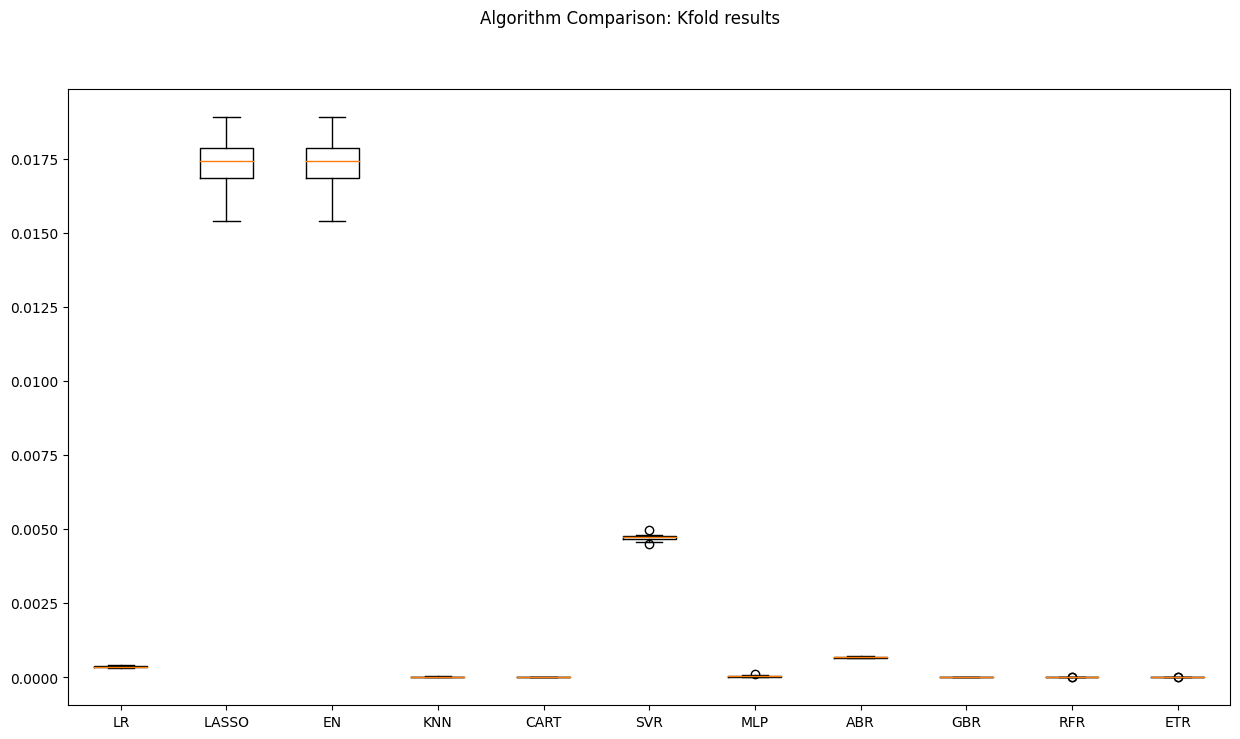

In [15]:
show_boxplot_kfold(kfold_results)

In order to get a better view, we remove the LASSO and Elastic Net

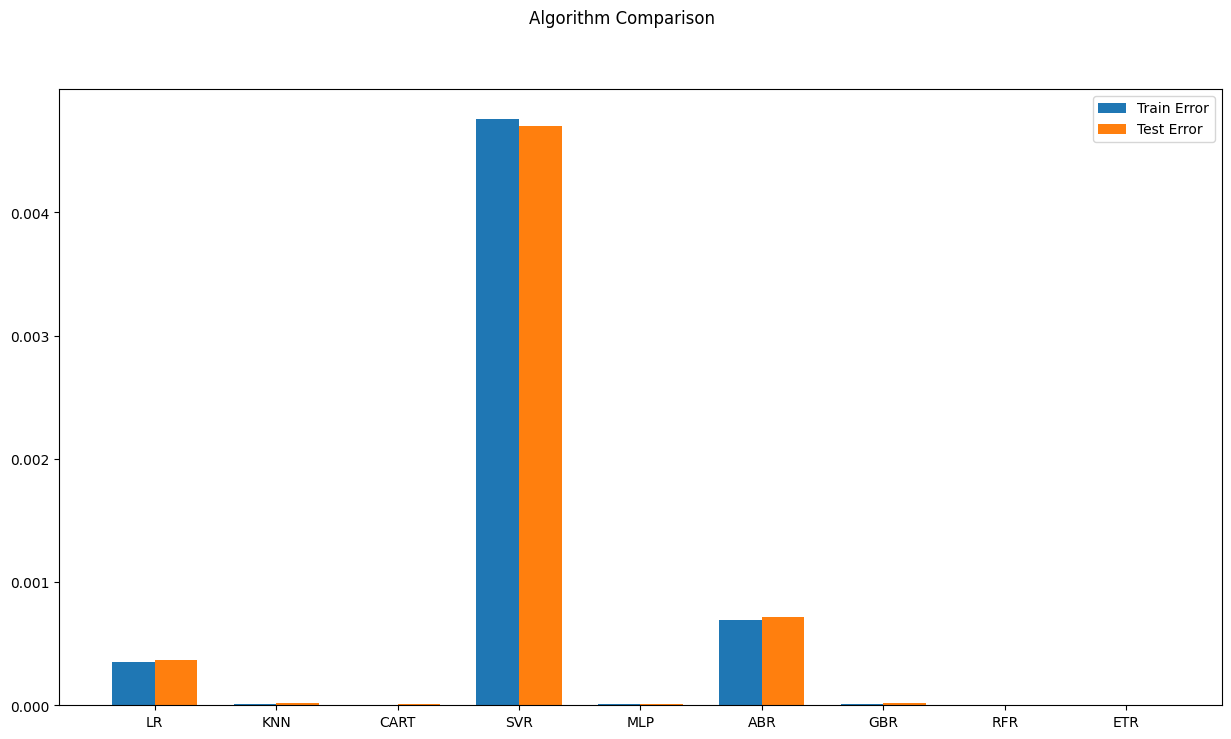

In [16]:
kfold_results.train_results = kfold_results.train_results[0:1] + kfold_results.train_results[3:]
kfold_results.test_results = kfold_results.test_results[0:1] + kfold_results.test_results[3:]
kfold_results.names = kfold_results.names[0:1] + kfold_results.names[3:]

show_bar_kfold(kfold_results)

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the CART and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.  

<a id='5'></a>
# 6. Model Tuning and finalising the model

As shown in the chart above the MLP model is one of the best models, so we perform the model tuning. We perform a grid search with different combination of hidden layers in the MLP model.  

In [17]:
params_search = ParamsGridSearch(
    model=MLPRegressor(),
    params_grid={'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]},
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
    seed=7,
    shuffle=True,
)

search_results = run_grid_search(params_search)


Best: -0.000067 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000537 (0.000406) with: {'hidden_layer_sizes': (20,)}
-0.000096 (0.000070) with: {'hidden_layer_sizes': (50,)}
-0.000088 (0.000127) with: {'hidden_layer_sizes': (20, 20)}
-0.000067 (0.000115) with: {'hidden_layer_sizes': (20, 30, 20)}


In [18]:
# Prepare model

model_tuned = MLPRegressor(hidden_layer_sizes=search_results.best_params_['hidden_layer_sizes'])
model_tuned.fit(X_train, Y_train)


MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [19]:
# Estimate accuracy on validation set. Transform the validation dataset

predictions = model_tuned.predict(X_test)
print(f'MSE error: {mean_squared_error(Y_test, predictions)}')


MSE error: 4.399856098880105e-05


We see that the mean error is roughly less than a cent. Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning.


<a id='6'></a>
# 7. Additonal analysis: removing the volatilty data

Next, we make the process harder by trying to predict the price without the volatility data.

In [20]:
X2 = X.drop(['Volatility'], axis=1)
validation_size = 0.2
total_size = X2.shape[0]
train_size = int(total_size * (1 - validation_size))

X_train, X_test = X2[0:train_size], X2[train_size:total_size]
Y_train, Y_test = Y[0:train_size], Y[train_size:total_size]


In [21]:
models = LINEAR_MODELS + NEURAL_NETWORK_MODELS + ENSEMBLE_MODELS
params = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
    seed=7,
    shuffle=True,
)
kfold_results = run_kfold_analysis(params)


LR: 0.002141 (0.000194) 0.002137 0.002266
LASSO: 0.017315 (0.001028) 0.017308 0.017590
EN: 0.017315 (0.001028) 0.017308 0.017590
KNN: 0.000015 (0.000008) 0.000009 0.000016
CART: 0.000007 (0.000001) 0.000000 0.000008
SVR: 0.005954 (0.000080) 0.005957 0.005886
MLP: 0.000061 (0.000092) 0.000024 0.000022
ABR: 0.000687 (0.000029) 0.000649 0.000670
GBR: 0.000019 (0.000001) 0.000015 0.000018
RFR: 0.000001 (0.000000) 0.000000 0.000001
ETR: 0.000000 (0.000000) 0.000000 0.000000


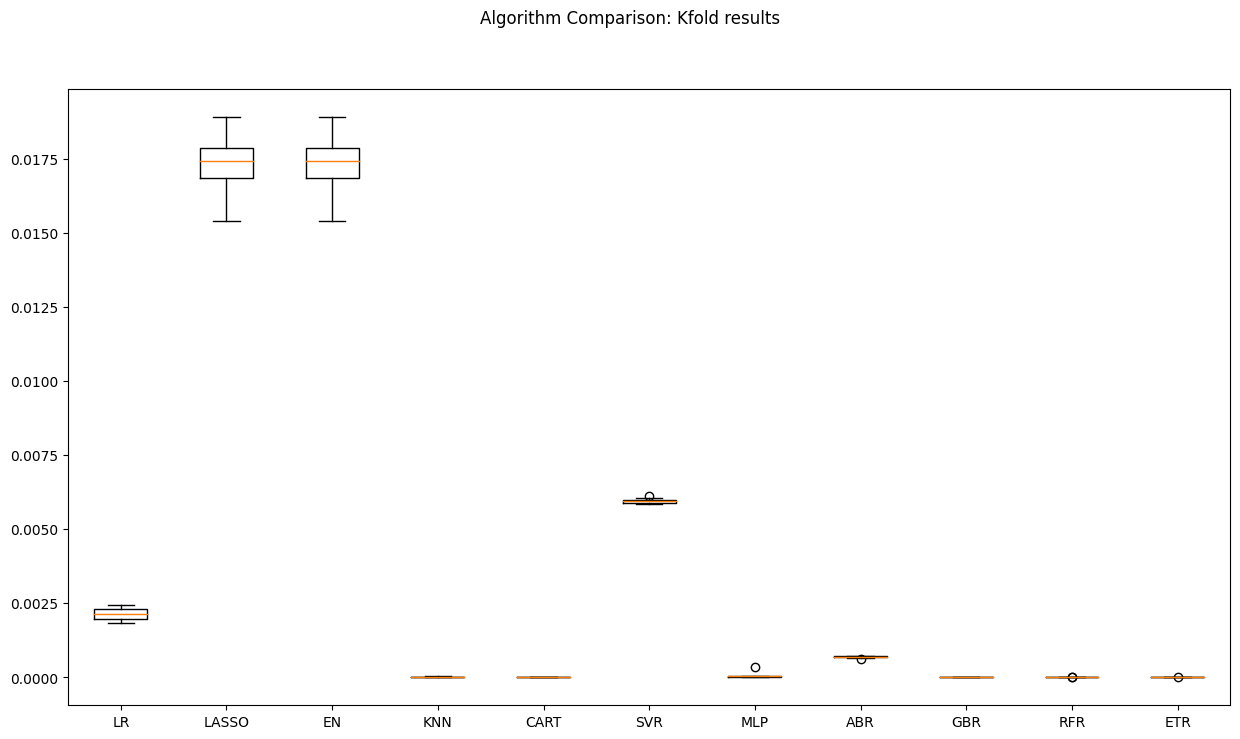

In [22]:
show_boxplot_kfold(kfold_results)


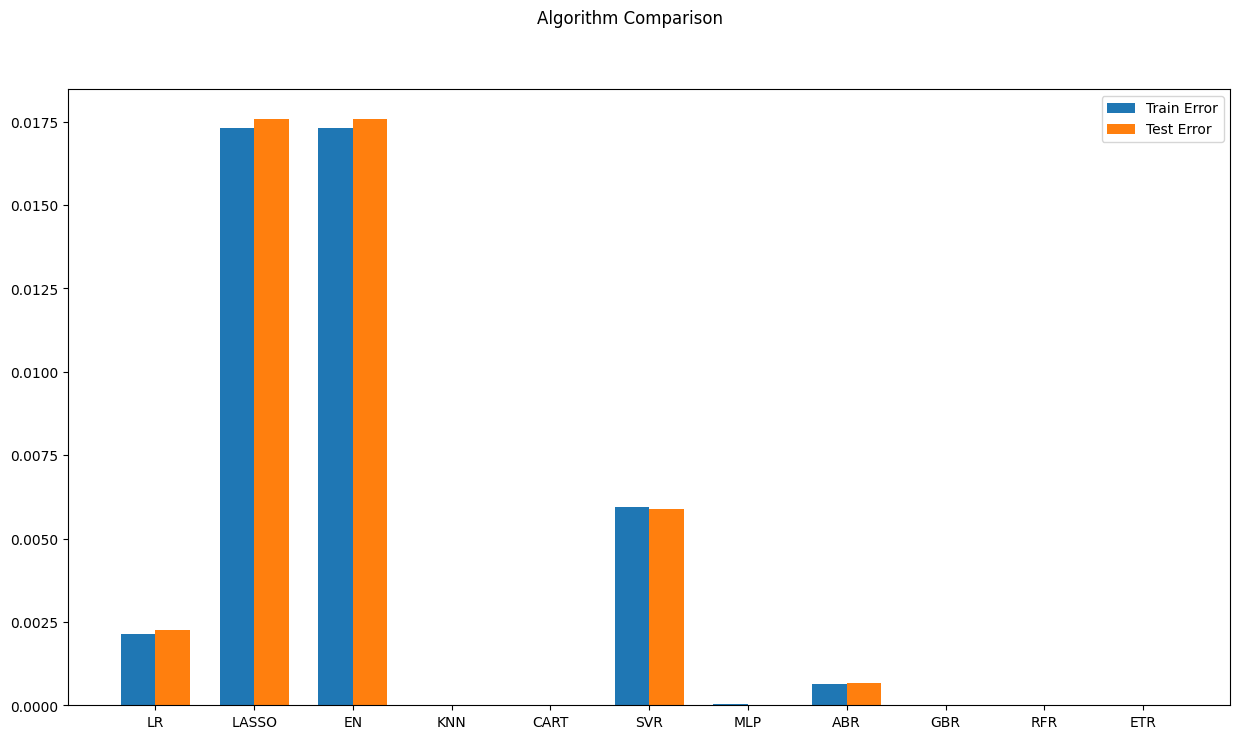

In [23]:
show_bar_kfold(kfold_results)

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.

### Summary

* The linear regression model did not do as well as our non-linear models and the non-linear models
have a very good performance overall. 

* Artificial neural network (ANN) can reproduce the Black and Scholes
option pricing formula for a call option to a high degree of accuracy which means that we can leverage the efficient numerical calculation of machine learning in the derivative pricing without relying on the impractical assumptions made in the traditional
derivative pricing models. 